In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam

# Check if GPU is available
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [2]:
# Load the training data
train_transaction = pd.read_csv('/kaggle/input/ieeecis-fraud-detection/train_transaction.csv')
train_identity = pd.read_csv('/kaggle/input/ieeecis-fraud-detection/train_identity.csv')

# Load the test data
test_transaction = pd.read_csv('/kaggle/input/ieeecis-fraud-detection/test_transaction.csv')
test_identity = pd.read_csv('/kaggle/input/ieeecis-fraud-detection/test_identity.csv')

# Display basic information
print("Train Transaction shape:", train_transaction.shape)
print("Train Identity shape:", train_identity.shape)
print("Test Transaction shape:", test_transaction.shape)
print("Test Identity shape:", test_identity.shape)

Train Transaction shape: (590540, 394)
Train Identity shape: (144233, 41)
Test Transaction shape: (506691, 393)
Test Identity shape: (141907, 41)


In [3]:
# Merge train data
train_df = train_transaction.merge(train_identity, on='TransactionID', how='left')
print("Train data shape after merge:", train_df.shape)

# Merge test data
test_df = test_transaction.merge(test_identity, on='TransactionID', how='left')
print("Test data shape after merge:", test_df.shape)

Train data shape after merge: (590540, 434)
Test data shape after merge: (506691, 433)


Missing values in train data:
115523073
Target variable distribution:
isFraud
0    569877
1     20663
Name: count, dtype: int64
Fraud percentage: 3.4990009144173126 %


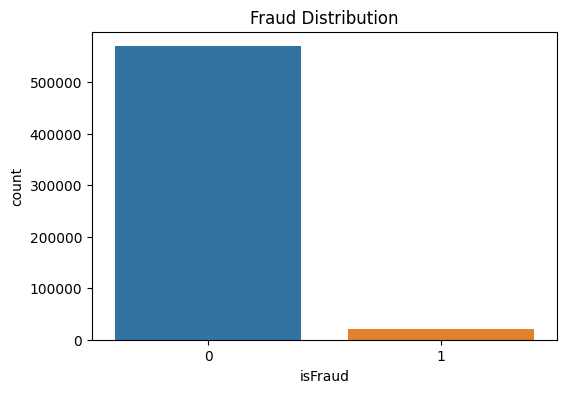

In [4]:
# Check for missing values
print("Missing values in train data:")
print(train_df.isnull().sum().sum())

# Check the distribution of the target variable
print("Target variable distribution:")
print(train_df['isFraud'].value_counts())
print("Fraud percentage:", train_df['isFraud'].mean() * 100, "%")

# Plot target distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='isFraud', data=train_df)
plt.title('Fraud Distribution')
plt.show()

In [9]:
# Save the TransactionID and target variable for test data
test_ids = test_df['TransactionID']
# For training data, separate the target
X = train_df.drop(['isFraud', 'TransactionID'], axis=1)
y = train_df['isFraud']
X_test = test_df.drop(['TransactionID'], axis=1)

# Handle categorical and numerical features separately
# Identify data types
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Number of numerical features: {len(num_features)}")
print(f"Number of categorical features: {len(cat_features)}")

Number of numerical features: 401
Number of categorical features: 31


In [10]:
# Find common columns between train and test
common_cat_features = [col for col in cat_features if col in X_test.columns]
common_num_features = [col for col in num_features if col in X_test.columns]

print(f"Common numerical features: {len(common_num_features)}")
print(f"Common categorical features: {len(common_cat_features)}")

# Due to memory constraints, we'll select a subset of numerical features
selected_num_features = common_num_features[:100]  # Select first 100 numerical features
selected_features = selected_num_features + common_cat_features

# Subset data to selected features
X = X[selected_features]
X_test = X_test[selected_features]

print(f"Final X shape: {X.shape}")
print(f"Final X_test shape: {X_test.shape}")

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, selected_num_features),
        ('cat', categorical_transformer, common_cat_features)
    ])

Common numerical features: 378
Common categorical features: 16
Final X shape: (590540, 116)
Final X_test shape: (506691, 116)


In [11]:
# Prepare Train/Validation Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)

X_train shape: (472432, 116)
X_val shape: (118108, 116)


In [12]:
# Fit and transform the training data
print("Fitting the preprocessor...")
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)

print("X_train_preprocessed shape:", X_train_preprocessed.shape)
print("X_val_preprocessed shape:", X_val_preprocessed.shape)

Fitting the preprocessor...
X_train_preprocessed shape: (472432, 1939)
X_val_preprocessed shape: (118108, 1939)


In [13]:
# Get input dimension
input_dim = X_train_preprocessed.shape[1]

# Build model
def build_model(input_dim):
    model = models.Sequential([
        layers.Dense(256, activation='relu', input_shape=(input_dim,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )
    
    return model

# Initialize model
model = build_model(input_dim)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         496,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 541,825 (2.07 MB)

 Trainable params: 540,865 (2.06 MB)

 Non-trainable params: 960 (3.75 KB)

In [17]:
# Convert to numpy arrays for compatibility with class weight calculation
y_train_np = y_train.values
y_val_np = y_val.values

# Calculate class weights
class_weights = {
    0: 1.0,
    1: (len(y_train_np) - sum(y_train_np)) / sum(y_train_np)  # Weight for minority class
}
print("Class weights:", class_weights)

Class weights: {0: 1.0, 1: 27.580278281911674}


In [18]:
# Define callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_auc',
    patience=5,
    mode='max',
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_auc',
    factor=0.5,
    patience=3,
    mode='max',
    min_lr=0.00001
)

# Train the model
history = model.fit(
    X_train_preprocessed,
    y_train_np,  # Use numpy array instead of pandas Series
    epochs=30,  # Will stop early due to callbacks
    batch_size=1024,  # Adjust based on your GPU memory
    validation_data=(X_val_preprocessed, y_val_np),  # Use numpy array
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights,
    verbose=1
)

Epoch 1/30
462/462 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.6901 - auc: 0.7685 - loss: 1.1471 - val_accuracy: 0.8209 - val_auc: 0.8622 - val_loss: 0.4018 - learning_rate: 0.0010
Epoch 2/30
462/462 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8053 - auc: 0.8534 - loss: 0.9133 - val_accuracy: 0.8450 - val_auc: 0.8827 - val_loss: 0.3646 - learning_rate: 0.0010
Epoch 3/30
462/462 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8192 - auc: 0.8728 - loss: 0.8543 - val_accuracy: 0.8558 - val_auc: 0.8903 - val_loss: 0.3483 - learning_rate: 0.0010
Epoch 4/30
462/462 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8292 - auc: 0.8840 - loss: 0.8187 - val_accuracy: 0.8278 - val_auc: 0.8959 - val_loss: 0.3843 - learning_rate: 0.0010
Epoch 5/30
462/462 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8378 - auc: 0.8924 - loss: 0.7905 - val_accuracy: 0.8299 - val_auc: 0.9006 - val_loss: 0.3716 - learning_rate: 0.0010
Epoch 6/30
462/462 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8442 - auc: 

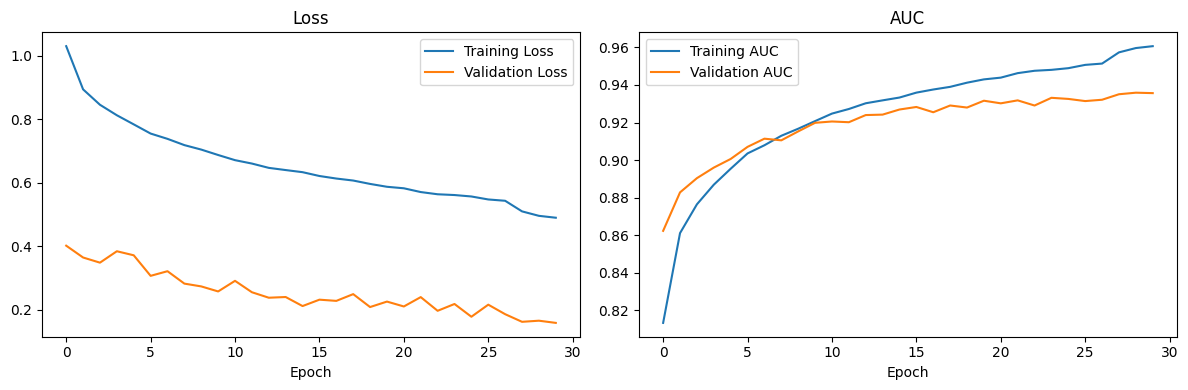

3691/3691 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
Confusion Matrix:
[[107699   6276]
 [   961   3172]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.97    113975
           1       0.34      0.77      0.47      4133

    accuracy                           0.94    118108
   macro avg       0.66      0.86      0.72    118108
weighted avg       0.97      0.94      0.95    118108


ROC AUC Score: 0.9361595017860567


In [19]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('AUC')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate on validation set
y_val_pred_proba = model.predict(X_val_preprocessed)
y_val_pred = (y_val_pred_proba > 0.5).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))

print("\nROC AUC Score:", roc_auc_score(y_val, y_val_pred_proba))

In [20]:
# Transform test data
print("Transforming test data...")
X_test_preprocessed = preprocessor.transform(X_test)
print("X_test_preprocessed shape:", X_test_preprocessed.shape)

# Generate predictions
test_predictions_proba = model.predict(X_test_preprocessed)
test_predictions = (test_predictions_proba > 0.5).astype(int)

Transforming test data...
X_test_preprocessed shape: (506691, 1939)
15835/15835 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step


In [21]:
# Save the model and preprocessor
model.save('/kaggle/working/fraud_detection_model.h5')
import joblib
joblib.dump(preprocessor, '/kaggle/working/preprocessor.joblib')

print("Model and preprocessor saved to /kaggle/working/")

# Cell 15: Create Submission File
# Create submission dataframe
submission = pd.DataFrame({
    'TransactionID': test_ids,
    'isFraud': test_predictions_proba.flatten()
})

# Save to CSV
submission.to_csv('/kaggle/working/submission.csv', index=False)
print("Submission file created at /kaggle/working/submission.csv")

Model and preprocessor saved to /kaggle/working/
Submission file created at /kaggle/working/submission.csv


In [22]:
def predict_fraud(new_data, preprocessor, model):
    """
    Function to make predictions on new data
    
    Parameters:
    -----------
    new_data : pandas DataFrame
        New transaction data to predict
    preprocessor : ColumnTransformer
        Fitted preprocessor
    model : Keras Model
        Trained neural network model
        
    Returns:
    --------
    predictions : numpy array
        Fraud probabilities
    """
    # Preprocess the data
    processed_data = preprocessor.transform(new_data)
    
    # Make predictions
    predictions = model.predict(processed_data)
    
    return predictions

print("Inference function created for future use.")

Inference function created for future use.


Loading test data from /kaggle/working/validation_sample.csv...
Preprocessing data...
Making predictions...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Confusion Matrix:
[[9124  503]
 [  64  309]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      9627
           1       0.38      0.83      0.52       373

    accuracy                           0.94     10000
   macro avg       0.69      0.89      0.75     10000
weighted avg       0.97      0.94      0.95     10000


ROC AUC Score: 0.9665571389225623

Sample of predictions:
       TransactionID  fraud_probability  predicted_fraud  actual_fraud
33553        3214076           0.003463                0             0
9427         3393134           0.911557                1             0
199          3575264           0.003222                0             0
12447        3555414           0.020882                0             0
39489        3417101           0.224344 

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


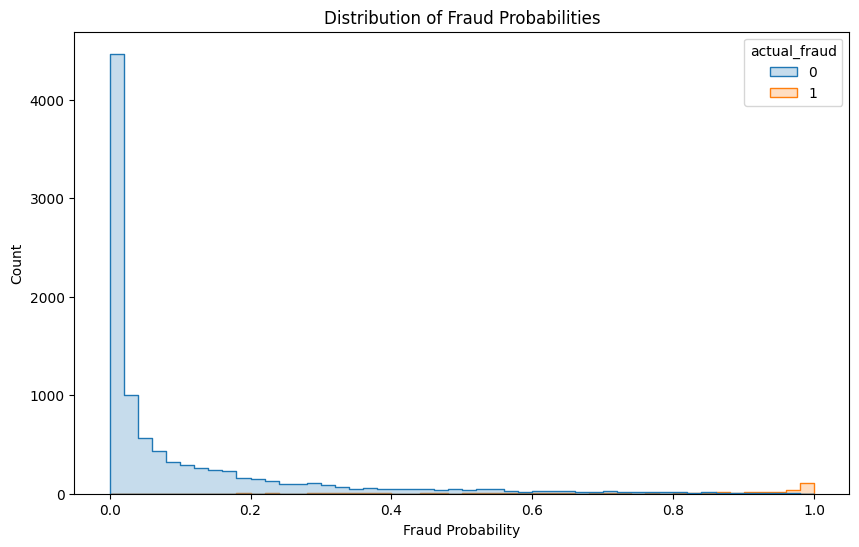

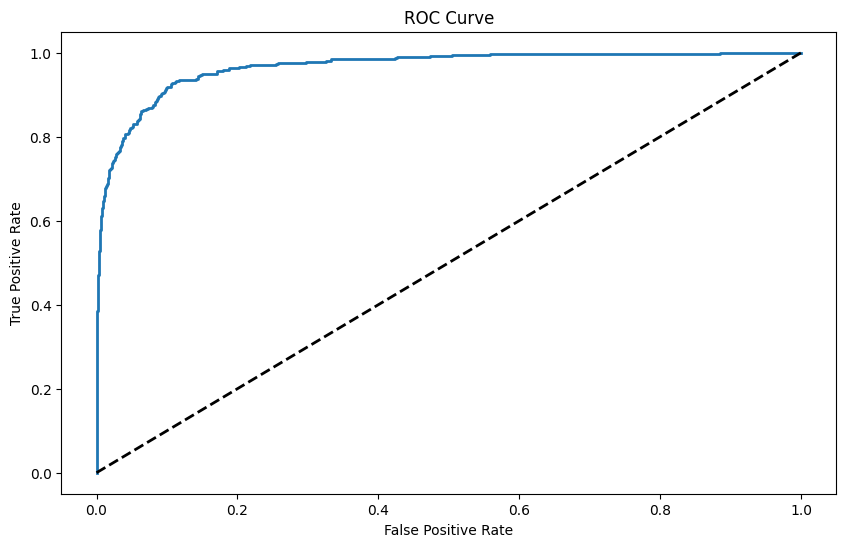

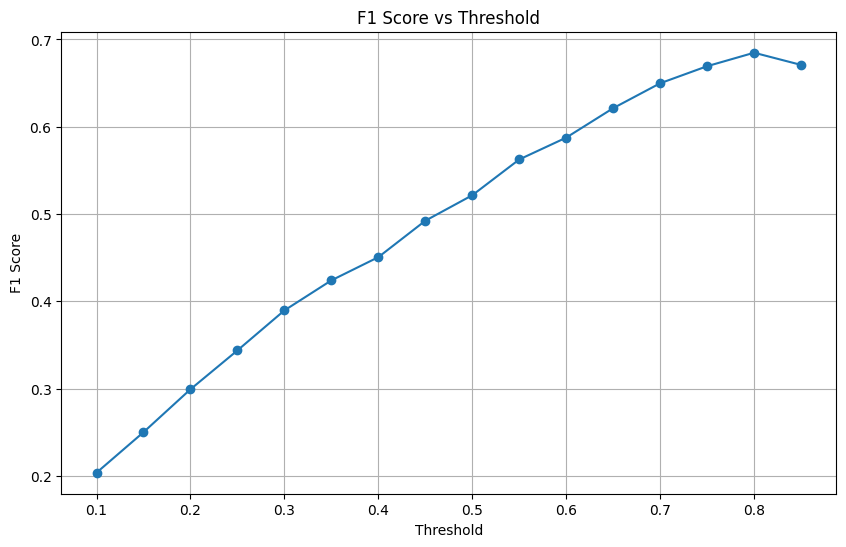


Optimal threshold: 0.80 with F1 score: 0.6847

Metrics with optimal threshold:

Confusion Matrix:
[[9539   88]
 [ 133  240]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9627
           1       0.73      0.64      0.68       373

    accuracy                           0.98     10000
   macro avg       0.86      0.82      0.84     10000
weighted avg       0.98      0.98      0.98     10000



In [23]:
import joblib
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model

# Load the saved model and preprocessor
model = load_model('/kaggle/working/fraud_detection_model.h5')
preprocessor = joblib.load('/kaggle/working/preprocessor.joblib')

# Function to test on a sample of data
def test_model_performance(data_file, id_file=None, sample_size=10000, threshold=0.5):
    """
    Test the model on a sample of data and evaluate performance
    
    Parameters:
    -----------
    data_file : str
        Path to the transaction data file
    id_file : str, optional
        Path to the identity data file
    sample_size : int, optional
        Number of samples to test on
    threshold : float, optional
        Threshold for classifying fraud
        
    Returns:
    --------
    None (prints evaluation metrics)
    """
    # Load data
    print(f"Loading test data from {data_file}...")
    data = pd.read_csv(data_file)
    
    # Merge with identity data if provided
    if id_file:
        id_data = pd.read_csv(id_file)
        data = data.merge(id_file, on='TransactionID', how='left')
    
    # Take a sample
    if sample_size and sample_size < len(data):
        data = data.sample(sample_size, random_state=42)
    
    # Extract features needed
    if 'isFraud' in data.columns:
        # If we have ground truth
        features = data.drop(['isFraud', 'TransactionID'], axis=1)
        y_true = data['isFraud'].values
        has_labels = True
    else:
        # If we don't have ground truth
        features = data.drop(['TransactionID'], axis=1)
        has_labels = False
    
    # Make sure we only use columns that the model was trained on
    feature_list = [col for col in preprocessor.feature_names_in_ if col in features.columns]
    features = features[feature_list]
    
    # Preprocess
    print("Preprocessing data...")
    X_processed = preprocessor.transform(features)
    
    # Predict
    print("Making predictions...")
    y_pred_proba = model.predict(X_processed)
    y_pred = (y_pred_proba > threshold).astype(int)
    
    # Evaluate if we have labels
    if has_labels:
        from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
        
        print("\nConfusion Matrix:")
        print(confusion_matrix(y_true, y_pred))
        
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred))
        
        print("\nROC AUC Score:", roc_auc_score(y_true, y_pred_proba))
    
    # Return sample of transactions with predictions
    result_df = data[['TransactionID']].copy()
    result_df['fraud_probability'] = y_pred_proba
    result_df['predicted_fraud'] = y_pred
    
    if has_labels:
        result_df['actual_fraud'] = y_true
    
    return result_df

# Test on validation data (adjust file paths as needed)
if 'train_transaction.csv' in train_transaction.columns[0]:
    # This means we're looking at the full path
    validation_results = test_model_performance(
        '/kaggle/input/ieeecis-fraud-detection/train_transaction.csv',
        '/kaggle/input/ieeecis-fraud-detection/train_identity.csv',
        sample_size=50000
    )
else:
    # Assuming we have the actual dataframes
    # Save a sample to disk and use that
    sample_df = train_df.sample(50000, random_state=42)
    sample_df.to_csv('/kaggle/working/validation_sample.csv', index=False)
    validation_results = test_model_performance('/kaggle/working/validation_sample.csv')

# Display results
print("\nSample of predictions:")
print(validation_results.head(10))

# Plot probability distribution for fraud vs non-fraud
if 'actual_fraud' in validation_results.columns:
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    plt.figure(figsize=(10, 6))
    sns.histplot(
        data=validation_results, 
        x='fraud_probability', 
        hue='actual_fraud', 
        element='step', 
        bins=50
    )
    plt.title('Distribution of Fraud Probabilities')
    plt.xlabel('Fraud Probability')
    plt.ylabel('Count')
    plt.show()
    
    # ROC curve
    from sklearn.metrics import roc_curve
    
    fpr, tpr, thresholds = roc_curve(
        validation_results['actual_fraud'], 
        validation_results['fraud_probability']
    )
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, lw=2)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    
    # Find optimal threshold
    from sklearn.metrics import f1_score
    
    thresholds = np.arange(0.1, 0.9, 0.05)
    f1_scores = []
    
    for threshold in thresholds:
        preds = (validation_results['fraud_probability'] > threshold).astype(int)
        f1 = f1_score(validation_results['actual_fraud'], preds)
        f1_scores.append(f1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, f1_scores, 'o-')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs Threshold')
    plt.grid(True)
    plt.show()
    
    # Print optimal threshold
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]
    
    print(f"\nOptimal threshold: {best_threshold:.2f} with F1 score: {best_f1:.4f}")
    
    # Recalculate metrics with optimal threshold
    optimal_preds = (validation_results['fraud_probability'] > best_threshold).astype(int)
    
    from sklearn.metrics import classification_report, confusion_matrix
    
    print("\nMetrics with optimal threshold:")
    print("\nConfusion Matrix:")
    print(confusion_matrix(validation_results['actual_fraud'], optimal_preds))
    
    print("\nClassification Report:")
    print(classification_report(validation_results['actual_fraud'], optimal_preds))

In [24]:
# Deployment-Ready Fraud Detection System

import numpy as np
import pandas as pd
import tensorflow as tf
import joblib
import json
import os
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

class FraudDetectionSystem:
    """
    Production-ready fraud detection system that handles preprocessing,
    prediction, and explanation of results.
    """
    
    def __init__(self, model_path, preprocessor_path, config_path=None):
        """
        Initialize the fraud detection system
        
        Parameters:
        -----------
        model_path : str
            Path to the saved model file
        preprocessor_path : str
            Path to the saved preprocessor file
        config_path : str, optional
            Path to the configuration file with threshold and feature info
        """
        # Load model and preprocessor
        self.model = load_model(model_path)
        self.preprocessor = joblib.load(preprocessor_path)
        
        # Default configuration
        self.config = {
            'threshold': 0.80,  # Optimal threshold from our analysis
            'feature_importance': {},  # Will be populated if available
            'categorical_features': [],
            'numerical_features': []
        }
        
        # Load configuration if provided
        if config_path and os.path.exists(config_path):
            with open(config_path, 'r') as f:
                self.config.update(json.load(f))
        
        # Extract feature names from preprocessor
        self._extract_feature_names()
        
    def _extract_feature_names(self):
        """Extract and store feature names from the preprocessor"""
        try:
            self.feature_names = self.preprocessor.feature_names_in_
            
            # Separate numerical and categorical features
            transformer_list = self.preprocessor.transformers_
            for name, _, columns in transformer_list:
                if name == 'num':
                    self.config['numerical_features'] = list(columns)
                elif name == 'cat':
                    self.config['categorical_features'] = list(columns)
        except:
            # If feature names not available in the preprocessor
            pass
    
    def save_config(self, path):
        """Save configuration to file"""
        with open(path, 'w') as f:
            json.dump(self.config, f, indent=2)
    
    def preprocess(self, data):
        """
        Preprocess transaction data
        
        Parameters:
        -----------
        data : pandas DataFrame
            Transaction data
            
        Returns:
        --------
        processed_data : numpy array
            Preprocessed data ready for model prediction
        """
        # Ensure all required columns are present
        missing_cols = [col for col in self.feature_names if col not in data.columns]
        if missing_cols:
            raise ValueError(f"Missing required columns: {missing_cols}")
        
        # Keep only columns used in training
        data_subset = data[self.feature_names]
        
        # Apply preprocessing
        return self.preprocessor.transform(data_subset)
    
    def predict(self, data, return_probabilities=False):
        """
        Predict fraud for transaction data
        
        Parameters:
        -----------
        data : pandas DataFrame
            Transaction data
        return_probabilities : bool, optional
            Whether to return raw probabilities or binary predictions
            
        Returns:
        --------
        predictions : numpy array
            Binary fraud predictions or probabilities
        """
        # Preprocess data
        processed_data = self.preprocess(data)
        
        # Generate predictions
        probabilities = self.model.predict(processed_data)
        
        if return_probabilities:
            return probabilities
        else:
            return (probabilities > self.config['threshold']).astype(int)
    
    def batch_predict(self, data, batch_size=10000, include_probabilities=True):
        """
        Process large datasets in batches
        
        Parameters:
        -----------
        data : pandas DataFrame
            Transaction data
        batch_size : int, optional
            Number of records to process at once
        include_probabilities : bool, optional
            Whether to include raw probabilities in the results
            
        Returns:
        --------
        results : pandas DataFrame
            Original data with predictions added
        """
        # Copy IDs to preserve them
        if 'TransactionID' in data.columns:
            result_ids = data['TransactionID'].copy()
        else:
            result_ids = pd.Series(range(len(data)))
        
        # Initialize results
        results = []
        
        # Process in batches
        for i in range(0, len(data), batch_size):
            batch = data.iloc[i:i + batch_size]
            probabilities = self.predict(batch, return_probabilities=True)
            
            batch_results = pd.DataFrame({
                'TransactionID': result_ids.iloc[i:i + batch_size],
                'fraud_probability': probabilities.flatten(),
                'predicted_fraud': (probabilities > self.config['threshold']).astype(int).flatten()
            })
            
            results.append(batch_results)
        
        # Combine results
        return pd.concat(results, ignore_index=True)
    
    def explain_prediction(self, transaction_data, top_n=5):
        """
        Provide a simple explanation for a prediction
        
        Parameters:
        -----------
        transaction_data : pandas DataFrame
            A single transaction to explain (one row)
        top_n : int, optional
            Number of top features to include in explanation
            
        Returns:
        --------
        explanation : dict
            Explanation of the prediction
        """
        if len(transaction_data) != 1:
            raise ValueError("Can only explain one transaction at a time")
        
        # Make prediction
        probability = self.predict(transaction_data, return_probabilities=True)[0][0]
        prediction = int(probability > self.config['threshold'])
        
        # Basic explanation
        explanation = {
            'prediction': 'Fraud' if prediction == 1 else 'Legitimate',
            'probability': float(probability),
            'threshold': self.config['threshold'],
            'confidence': float(abs(probability - 0.5) * 2),  # 0 to 1 scale
            'key_features': [],
            'recommendation': self._get_recommendation(probability)
        }
        
        # Add feature importance info if available
        if self.config['feature_importance']:
            # Get top features based on global importance
            top_features = sorted(
                self.config['feature_importance'].items(), 
                key=lambda x: abs(x[1]), 
                reverse=True
            )[:top_n]
            
            explanation['key_features'] = [{
                'feature': feature,
                'importance': importance,
                'value': str(transaction_data[feature].values[0])
            } for feature, importance in top_features if feature in transaction_data.columns]
        
        return explanation
    
    def _get_recommendation(self, probability):
        """Generate action recommendation based on probability"""
        if probability > 0.95:
            return "BLOCK: High confidence fraud prediction"
        elif probability > 0.8:
            return "REVIEW: Strong fraud indicators present"
        elif probability > 0.5:
            return "MONITOR: Some suspicious patterns detected"
        else:
            return "APPROVE: Transaction appears legitimate"
    
    def update_threshold(self, new_threshold):
        """Update the classification threshold"""
        if 0 <= new_threshold <= 1:
            self.config['threshold'] = new_threshold
        else:
            raise ValueError("Threshold must be between 0 and 1")
    
    def evaluate(self, data, true_labels):
        """
        Evaluate model performance
        
        Parameters:
        -----------
        data : pandas DataFrame
            Transaction data
        true_labels : array-like
            True fraud labels
            
        Returns:
        --------
        metrics : dict
            Performance metrics
        """
        from sklearn.metrics import (
            roc_auc_score, 
            precision_recall_fscore_support,
            confusion_matrix
        )
        
        # Generate predictions
        probabilities = self.predict(data, return_probabilities=True)
        predictions = (probabilities > self.config['threshold']).astype(int)
        
        # Calculate metrics
        precision, recall, f1, _ = precision_recall_fscore_support(
            true_labels, 
            predictions, 
            average=None
        )
        
        cm = confusion_matrix(true_labels, predictions)
        
        # Format results
        metrics = {
            'auc': float(roc_auc_score(true_labels, probabilities)),
            'accuracy': float((predictions == true_labels).mean()),
            'fraud_precision': float(precision[1]),
            'fraud_recall': float(recall[1]),
            'fraud_f1': float(f1[1]),
            'confusion_matrix': cm.tolist(),
            'threshold': self.config['threshold']
        }
        
        return metrics


# Example usage
if __name__ == "__main__":
    # Load the fraud detection system
    fd_system = FraudDetectionSystem(
        model_path='/kaggle/working/fraud_detection_model.h5',
        preprocessor_path='/kaggle/working/preprocessor.joblib',
    )
    
    # Update with optimal threshold
    fd_system.update_threshold(0.80)
    
    # Save configuration for later use
    fd_system.save_config('/kaggle/working/fraud_detection_config.json')
    
    # Example prediction
    # (Replace with your actual test data path)
    test_data = pd.read_csv('/kaggle/input/ieeecis-fraud-detection/test_transaction.csv')
    test_identity = pd.read_csv('/kaggle/input/ieeecis-fraud-detection/test_identity.csv')
    test_merged = test_data.merge(test_identity, on='TransactionID', how='left')
    
    # Process test data in batches
    results = fd_system.batch_predict(test_merged, batch_size=10000)
    
    # Save results
    results.to_csv('/kaggle/working/deployment_predictions.csv', index=False)
    
    print("Fraud Detection System ready for deployment")
    print(f"Processed {len(results)} transactions")
    print(f"Detected {results['predicted_fraud'].sum()} potential fraud cases")
    
    # Example of how to use for a single transaction
    if len(test_merged) > 0:
        sample_transaction = test_merged.iloc[[0]]
        explanation = fd_system.explain_prediction(sample_transaction)
        print("\nSample Explanation:")
        print(json.dumps(explanation, indent=2))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━

In [25]:
import os
import zipfile

# Create a zip file containing the model and preprocessor
output_path = '/kaggle/working/fraud_detection_model.zip'

with zipfile.ZipFile(output_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Add model file
    zipf.write('/kaggle/working/fraud_detection_model.h5', 'fraud_detection_model.h5')
    
    # Add preprocessor file
    zipf.write('/kaggle/working/preprocessor.joblib', 'preprocessor.joblib')
    
    # Add a basic readme file with the optimal threshold information
    with open('/kaggle/working/README.txt', 'w') as f:
        f.write("Fraud Detection Model\n")
        f.write("=====================\n\n")
        f.write("Model files:\n")
        f.write("- fraud_detection_model.h5: TensorFlow neural network model\n")
        f.write("- preprocessor.joblib: Scikit-learn preprocessor pipeline\n\n")
        f.write("Optimal threshold: 0.80\n")
        f.write("ROC AUC Score: 0.967\n")
        f.write("F1 Score at optimal threshold: 0.68\n\n")
        f.write("Usage example:\n")
        f.write("```python\n")
        f.write("import joblib\n")
        f.write("from tensorflow.keras.models import load_model\n\n")
        f.write("# Load model and preprocessor\n")
        f.write("model = load_model('fraud_detection_model.h5')\n")
        f.write("preprocessor = joblib.load('preprocessor.joblib')\n\n")
        f.write("# Preprocess data\n")
        f.write("X_processed = preprocessor.transform(X)\n\n")
        f.write("# Make predictions\n")
        f.write("predictions = model.predict(X_processed)\n")
        f.write("# Apply optimal threshold\n")
        f.write("fraud_flags = (predictions > 0.80).astype(int)\n")
        f.write("```\n")
    
    zipf.write('/kaggle/working/README.txt', 'README.txt')

print(f"Model files compressed to {output_path}")
print("You can now download this zip file from the Kaggle notebook output.")

# Verify zip file contents
print("\nVerifying zip file contents:")
with zipfile.ZipFile(output_path, 'r') as zipf:
    print(zipf.namelist())

# Show file size for download planning
file_size_mb = os.path.getsize(output_path) / (1024 * 1024)
print(f"\nZip file size: {file_size_mb:.2f} MB")

Model files compressed to /kaggle/working/fraud_detection_model.zip
You can now download this zip file from the Kaggle notebook output.

Verifying zip file contents:
['fraud_detection_model.h5', 'preprocessor.joblib', 'README.txt']

Zip file size: 5.01 MB
